# Exercise 3: Community detection on the network of Computational Social Scientists.
## Week 6, Exercise 4

- Consider the network you built in Week 4.

In [1]:
import json
import networkx as nx
import numpy as np
import netwulf as nw
from netwulf import visualize
from tqdm import tqdm


f = open('data/graph.json')
data = json.load(f)


In [2]:
G = nx.node_link_graph(data) 
print(f"The number of nodes before the GCC has been found: {len(list(G.nodes))}")
largest_cc = max(nx.connected_components(G), key=len)
# update graph to only include the larget connected component. 
G = G.subgraph(largest_cc)
print(f"The number of nodes after the GCC has been found: {len(list(G.nodes))}")

The number of nodes before the GCC has been found: 2162
The number of nodes after the GCC has been found: 1271


In [65]:
import community


# Find all communities in the graph
partition = community.best_partition(G)  # This returns inconsistent results. TODO: FORCE 30 COMMUNITIES
num_communities = len(set(partition.values()))

# Number of communities
print(f"Number of communities found: {num_communities}")
_, counts = np.unique(list((partition.values())), return_counts=True)

# Community sizes
print("\nCommunity : Count")
kek = 4
for i in range(0, len(counts), kek):
    for com, c in zip(list(range(i, i+kek)), counts[i:i+kek]):
        print(f"{com} : {c} ", end="| ")
    print()


# Modularity
modularity = community.modularity(partition, G)  # TODO: Write the proper modularity in MD
print(f"\nThe modularity of the graph is: {modularity}")

Number of communities found: 32

Community : Count
0 : 27 | 1 : 27 | 2 : 61 | 3 : 18 | 
4 : 62 | 5 : 52 | 6 : 46 | 7 : 67 | 
8 : 80 | 9 : 22 | 10 : 29 | 11 : 2 | 
12 : 42 | 13 : 120 | 14 : 86 | 15 : 53 | 
16 : 41 | 17 : 30 | 18 : 22 | 19 : 39 | 
20 : 78 | 21 : 18 | 22 : 17 | 23 : 5 | 
24 : 31 | 25 : 41 | 26 : 37 | 27 : 36 | 
28 : 18 | 29 : 20 | 30 : 27 | 31 : 17 | 

The modularity of the graph is: 0.8986595524754487


- Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?
> The modularity is 0.899, which is significantly different than 0. Modularity measures <> and is found within the range [-1/2, 1]. Thus, this partition is well done. 

- If you are curious, you can also try the Infomap algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in advanced topics 9B.

- Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their community. Describe the structure you observe.
- Make sure you save the assignment of authors to communities.
> The structure looks fine as hell. XYZ PROPER TERMS HERE.

In [4]:
nx.set_node_attributes(G, partition, name="group")  # group controls color
# visualize(G)

# INCLUDE SEXY SCREEN SHOT HERE

# Exercise 4: TF-IDF and the Computational Social Science communities.
## Week 8, Exercise 1
The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> Student critic: Calculate TF-IDF for each word in each community. THEN, find top 10 lists across community. As you'll see, there will be some redundancy, because we strictly follow your instructions. SUGGESTION: For better coding practice, have us write specific functions that we can call in the main code to answer your questions.

## 4.1) Check wikipedia for TF-IDF.
Explain in your own words the point of TF-IDF. What does TF and IDF stand for?
> Short for `term frequency–inverse document frequency`, it is a method applied in information retrieval (IR) that down weighs frequent terms. This is important, because word frequencies decrease logarithmically by rank cf. Zipf's law, and we want to avoid that the most frequent words dominate the analysis. 


## 4.2) Community abstracts
Now, we want to find out which words are important for each community, so we're going to create several **large documents, one for each community**. Each document includes all the tokens of abstracts written by members of a given community.

- Consider a community c
- Find all the abstracts of papers written by a (ALL) member(S) of community c.
- Create a long array that stores all the abstract tokens
- Repeat for all the communities.

> This is quite the task. For completeness the tokenized abstracts are genereated here with code from week 7.

In [5]:
# Tokenizer code written in week7

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

urls = '\S+www\S+\w'    # remove urls by searching for www
symbols = '[^\w\s]'     # remove punctuation
numbers = '\d+'         # remove numbers
stop_words = stopwords.words('english')
ps = PorterStemmer()    # Stemming

def tokenize(text):
    if text is None:
        return None
    text = text.lower()
    text = re.sub(fr'{symbols}|{urls}|{numbers}','',text)
    text = [ps.stem(word) for word in text.split() if word not in stop_words] 
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import pickle  # HACK DELETE LATER

# abstracDataSet contains paperId and their abstracts
# paperDataSet contains paperId	title	year	externalId.DOI	citationCount	fields	authorIds	author_field

with open('data/paperAbstractDataSet.pkl', 'rb') as f:
    abstractDataSet = pickle.load(f)
abstractDataSet=abstractDataSet.drop_duplicates(subset=['papersId'])

with open('data/ccs_papers.pkl', 'rb') as f:
    paperDataSet = pickle.load(f)

paperDataSet.shape
# 0.5 min

(969493, 8)

> We need access to the papers written by the authors in the graph. We have a paperDataSet that has up to a million entrees. This is cut down by filtering out papers where none of the contributors exists in the graph. The `explode` command is used, because the `authors` column is a list of authors.

In [7]:
temp = dict(G.nodes)
valid = paperDataSet['authorIds'].apply(lambda x: any(elem in temp for elem in x))
papers = paperDataSet[valid]         # Filter out papers with authors not in graph
papers = papers.explode('authorIds') # Explode the authorIds column

> Now collect all unique paperIDs for each community using sets.

In [8]:
communityPaperIDs = [set() for _ in range(num_communities)]
for node in tqdm(G.nodes(data=True)):
    author = node[0]
    writtenPapers=papers[papers["authorIds"].isin([author])]["paperId"]
    community = partition[author]
    communityPaperIDs[community].update(writtenPapers)

100%|██████████| 1271/1271 [00:07<00:00, 177.71it/s]


> With the paperIDS, the corresponding abstracts are found in the abstracts dataset. 
The abstracts are then tokenized and stored in a list for each community.

In [9]:
corpus = [[] for _ in range(len(communityPaperIDs))]


for i, paperIDs in tqdm(enumerate(communityPaperIDs)):
    abstracts=abstractDataSet[abstractDataSet["papersId"].isin(paperIDs)]["papersAbstract"]

    abstracts = abstracts.dropna()    # Drop all rows with None values
    abstracts.apply(lambda x: corpus[i].extend(tokenize(x)))

# 7 minutes

30it [05:05, 10.19s/it]


## 4.3) Calculate TF
Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the top 5 communities (by number of authors).

> First isolate the tokens of the top 5 communities. Then Cacluate TF for each token in each community.

In [10]:
# First find top 5 comminutes by size
top5communities = np.argsort(counts)[-5:][::-1]
# top5tokens = [communityTokens[x] for x in top5communities]
print("Top 5 communities:", top5communities)
corpus5 = [corpus[x] for x in top5communities]


Top 5 communities: [13 14  2  8 20]


In [11]:
# Calculate the tf for each community
from collections import Counter
TF5 = [Counter(tokens) for tokens in corpus5]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF5):
    for key in tf:
        tf[key] /= len(corpus5[i])

In [12]:
# Find the top 5 terms for each community
top5terms = [tf.most_common(5) for tf in TF5]
top5terms = [list(zip(*terms))[0] for terms in top5terms] # Extract the terms

print("Top 5 terms for each community:")
for i, terms in zip(top5communities, top5terms):
    print(f"{i}) : {terms}")

Top 5 terms for each community:
13) : ('use', 'user', 'social', 'studi', 'data')
14) : ('use', 'user', 'social', 'data', 'design')
2) : ('network', 'use', 'social', 'data', 'model')
8) : ('use', 'social', 'data', 'inform', 'user')
20) : ('model', 'use', 'algorithm', 'data', 'inform')


- Describe similarities and differences between the communities.
> Similarities include **use, user, social, data, and inform**. 

> Differences include **studi, model, design, and algorithm**.

- Why aren't the TFs not necessarily a good description of the communities?
> TF alone does not consider the significance of a word, i.e. words that in general appear often will unfailry score high. 

- Next, we calculate IDF for every word.
> The IDF is calculated where it is assumed that each community has one document, such that N = number of communities. First determine the number of communities that contain a given word. Then calculate the IDF for each word.

$$
IDF = \log\left(\frac{N}{n}\right),
$$
where $N$ is the total number of communities and $n$ is the number of communities that contain the word.

In [13]:
# Compute IDF for every term
IDF5 = Counter()
N = len(corpus5)

# For each term, count the number of communities that contain it
for c in corpus5:
    for term in set(c):
        IDF5[term] += 1

# Compute the IDF
IDF5 = {key: np.log(N / value) for key, value in IDF5.items()}

- What base logarithm did you use? Is that important?
> Natural logirithm. Not important, we are just interested in projecting onto the log scale.

## 4.4) TF-IDF
We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:

- List the 10 top TF words

In [14]:
# First find top 9 communities by size
N = 9
top9communities = np.argsort(counts)[-N:][::-1]
print(f"Top {N} communities:", top9communities)
corpus9 = [corpus[x] for x in top9communities]

# Calculate the tf for each community
from collections import Counter
TF9 = [Counter(tokens) for tokens in corpus9]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF9):
    for key in tf:
        tf[key] /= len(corpus9[i])

top10terms9 = [tf.most_common(10) for tf in TF9]
top10terms9 = [list(zip(*terms))[0] for terms in top10terms9] # Extract the terms

print("Top 10 terms for each community:")
for i, terms in zip(top9communities, top10terms9):
    print(f"{i}) : {terms}")

Top 9 communities: [13 14  2  8 20 19  5 18  7]
Top 10 terms for each community:
13) : ('use', 'user', 'social', 'studi', 'data', 'research', 'work', 'system', 'inform', 'model')
14) : ('use', 'user', 'social', 'data', 'design', 'system', 'research', 'inform', 'studi', 'commun')
2) : ('network', 'use', 'social', 'data', 'model', 'system', 'mobil', 'inform', 'studi', 'result')
8) : ('use', 'social', 'data', 'inform', 'user', 'algorithm', 'studi', 'time', 'model', 'result')
20) : ('model', 'use', 'algorithm', 'data', 'inform', 'result', 'problem', 'show', 'effect', 'learn')
19) : ('model', 'use', 'system', 'data', 'develop', 'research', 'social', 'paper', 'studi', 'differ')
5) : ('network', 'use', 'data', 'model', 'social', 'user', 'inform', 'studi', 'result', 'commun')
18) : ('network', 'use', 'user', 'data', 'system', 'model', 'differ', 'studi', 'result', 'perform')
7) : ('use', 'user', 'network', 'data', 'system', 'model', 'social', 'inform', 'result', 'studi')


- List the 10 top TF-IDF words


In [15]:
IDF9 = Counter()
N = len(corpus9)

# For each term, count the number of communities that contain it
for c in corpus9:
    for term in set(c):
        IDF9[term] += 1

# Compute the IDF
IDF9 = {key: np.log(N / value) for key, value in IDF9.items()}

# Compute TF-IDF for each community
TFIDF9 = [Counter() for _ in range(N)]
for i, tf in enumerate(TF9):
    for term in tf:
        TFIDF9[i][term] = tf[term] * IDF9[term]

# Extract the top 10 terms for each community
top10terms9 = [tf.most_common(10) for tf in TFIDF9]
top10terms9 = [list(zip(*terms))[0] for terms in top10terms9] # Extract the terms

print("Top 10 terms for each community:")
for i, terms in zip(top9communities, top10terms9):
    print(f"{i}) : {terms}")



Top 10 terms for each community:
13) : ('dram', 'codemix', 'phish', 'streamit', 'transliter', 'bangalor', 'bitwis', 'rbac', 'hcid', 'hpv')
14) : ('earthworm', 'searcher', 'microfilm', 'psl', 'ubuntu', 'odk', 'remix', 'serp', 'psnp', 'vape')
2) : ('auger', 'neutrino', 'mbb', 'aria', 'tota', 'cosmic', 'deli', 'sociometr', 'menti', 'saper')
8) : ('corros', 'childless', 'gull', 'maritim', 'childbear', 'whale', 'calv', 'amort', 'alloy', 'anod')
20) : ('bidder', 'ç', 'estimand', 'dpp', 'actr', 'ewa', 'pprl', 'bandit', 'regret', 'abhijit')
19) : ('ogd', 'rri', 'landus', 'abm', 'pil', 'lg', 'ssc', 'egovern', 'landcov', 'exurban')
5) : ('smallsid', 'eip', 'dasymetr', 'knot', 'ghsl', 'lowcred', 'corex', 'hashcod', 'ssg', 'antisci')
18) : ('bci', 'eeg', 'cortic', 'pbase', 'eegbas', 'neuroelectr', 'hyperscan', 'theta', 'pdc', 'neurophysiolog')
7) : ('bitext', 'diacrit', 'mmorpg', 'malwar', 'searcher', 'gaminganywher', 'dn', 'dnssec', 'qoe', 'gfg')


- List the top 3 authors (by degree)

In [16]:
# Determine degree of all nodes
import pandas as pd
degree = dict(G.degree())
nx.set_node_attributes(G, degree, name="degree") 
df=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# Extract top 3 authors for each community by degree
top3authors = []
for i in range(num_communities):
    authors = [node for node in G.nodes(data=True) if node[1]['group'] == i]
    top3authors.append(sorted(authors, key=lambda x: x[1]['degree'], reverse=True)[:3])
    # Extract their names
    top3authors[i] = [x[1]['name'] for x in top3authors[i]]

print("Top 3 authors for each community:")
for i in top9communities:
    authors = top3authors[i]
    print(f"{i}) : {authors}")

Top 3 authors for each community:
13) : ['Joyojeet Pal', 'Priyanka Chandra', 'Vaishnav Kameswaran']
14) : ['Munmun De Choudhury', 'Sarita Yardi Schoenebeck', 'Neha Kumari Pawan Kumar']
2) : ['Alexander Sandy Pentland', 'Iyad Rahwan', 'Johannes Bjelland']
8) : ['Ingmar G. Weber', 'Masoomali Fatehkia', 'Ridhi Kashyap']
20) : ['Duncan J. Watts', 'Markus M. Mobius', 'Sharad Chandra Goel']
19) : ['Jeroen Van Den Hoven', 'John Gareth Polhill', 'Federico Bianchi']
5) : ['Michael D. Conover', "M'arton Karsai", 'Filippo Menczer']
18) : ['Daniele Quercia', 'Vito Latora', 'Luca Maria Aiello']
7) : ['Haewoon Kwak', 'Krishna P. Gummadi', 'Meeyoung Cha']


- Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
> Looking at the output from the code just before the one above... Yes! As opposed to before where there was large overlap, now are exclusive to each community. 

# Exercise 5: The Wordcloud
## Week 8, Exercise 2
It's time to visualize our results!

- Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
- Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration).
> First compute the TF-IDF for each word in each community. Then, extract top three authors and finally create a wordcloud for each community.

In [18]:
# Calculate the tf for each community
N = len(corpus)
TF = [Counter(tokens) for tokens in corpus]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF):
    for key in tf:
        tf[key] /= len(corpus[i])

# Compute IDF for every term
IDF = Counter()
N = len(corpus)

# For each term, count the number of communities that contain it
for c in corpus:
    for term in set(c):
        IDF[term] += 1

# Compute the IDF
IDF = {key: np.log(N / value) for key, value in IDF.items()}

# Compute TF-IDF for each community
TF_IDF = [Counter() for _ in range(N)]
for i, tf in enumerate(TF):
    for term in tf:
        TF_IDF[i][term] = tf[term] * IDF[term]



In [ ]:
# Extract the top 3 authors (by degree) for each community
top3authors = []
for i in range(num_communities):
    authors = [node for node in G.nodes(data=True) if node[1]['group'] == i]
    top3authors.append(sorted(authors, key=lambda x: x[1]['degree'], reverse=True)[:3])
    top3authors[i] = [x[1]['name'] for x in top3authors[i]]  # Extract their names

texts = [" ".join(TF_IDF[i]) for i in range(num_communities)]

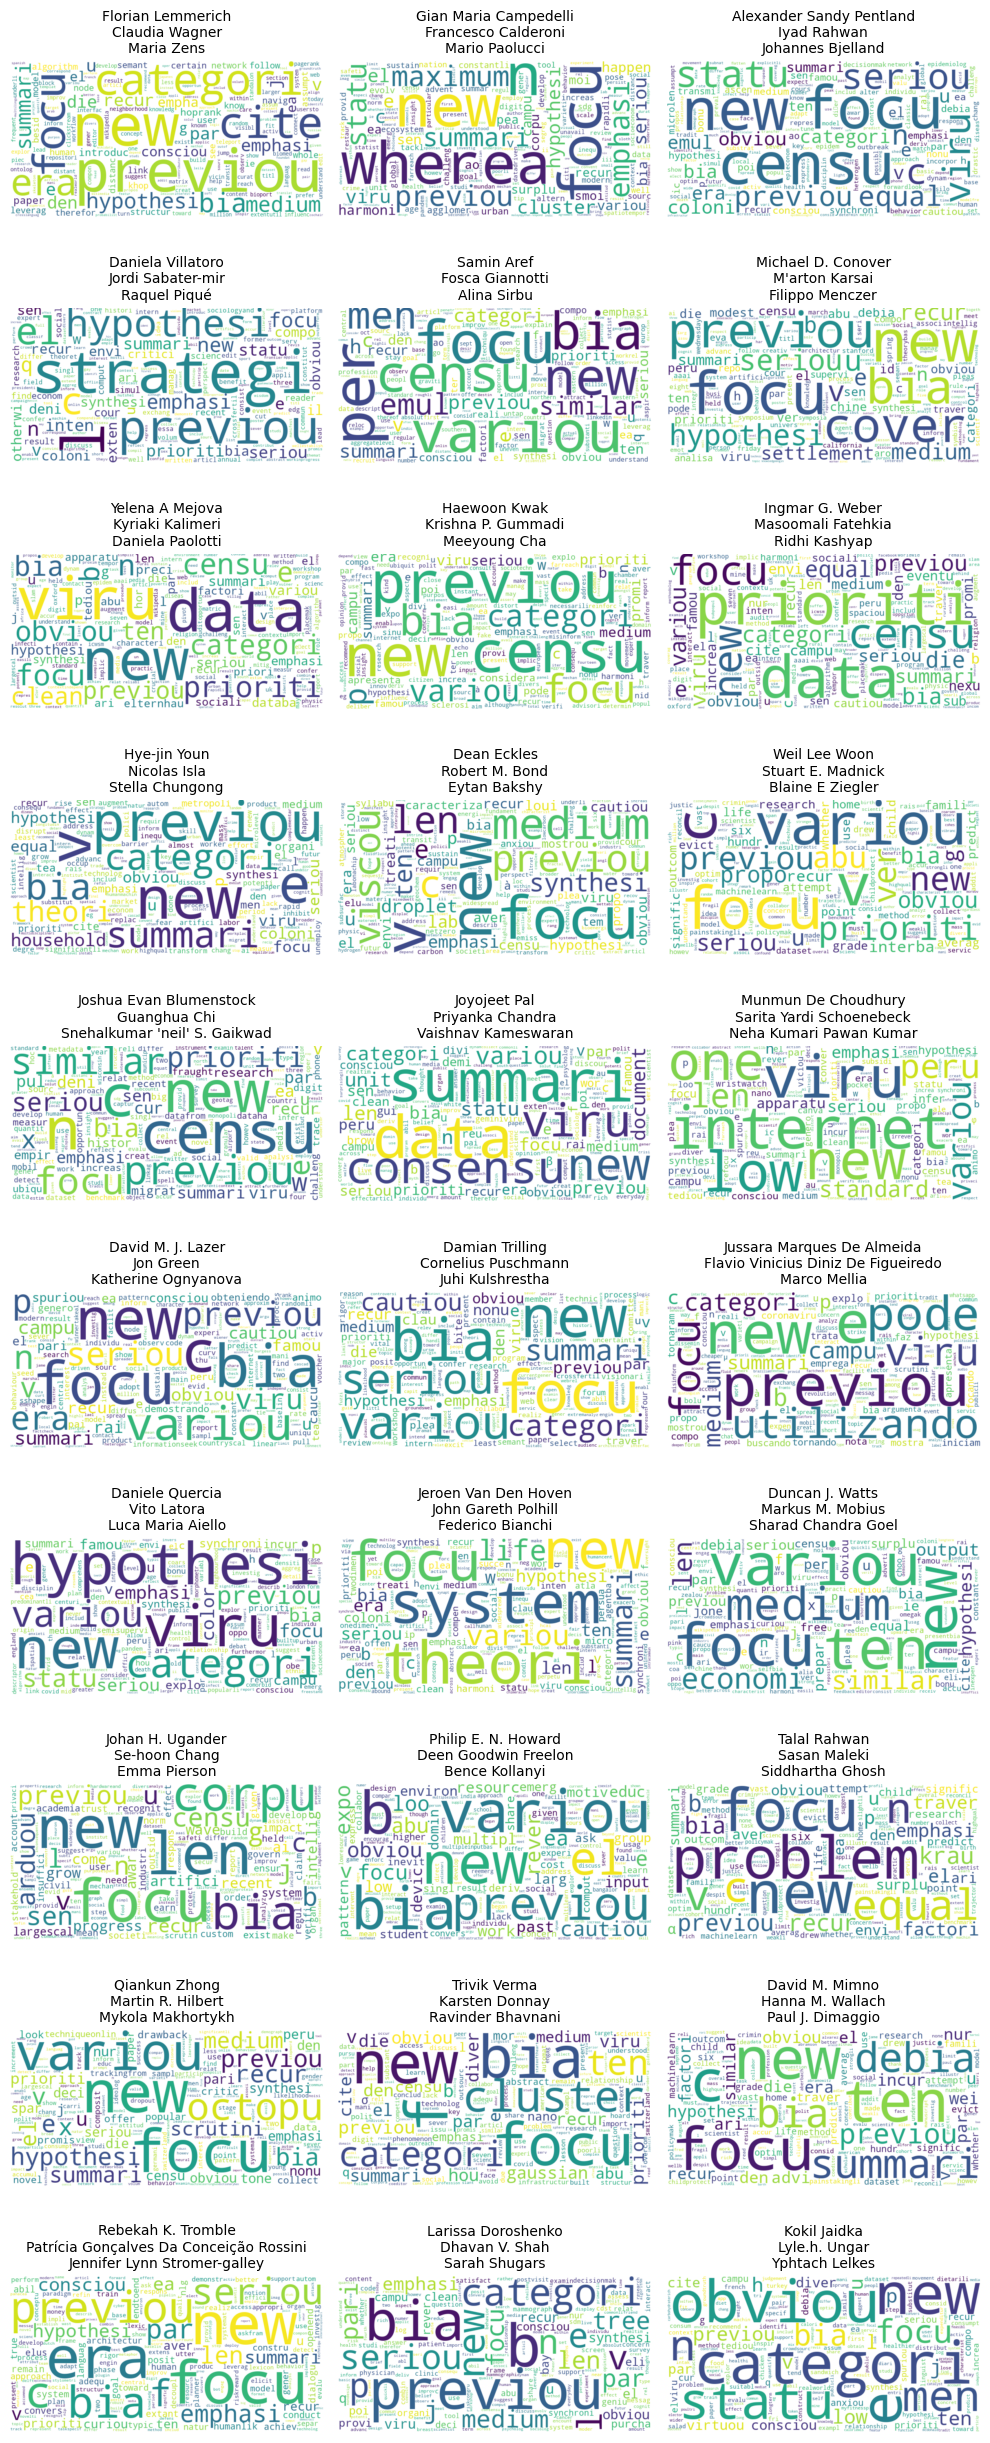

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Generate wordclouds for each community with suplots
fig, axes = plt.subplots(10, 3, figsize=(10, 25))
for i, ax in enumerate(axes.flatten()):
    text = texts[i]
    wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title("\n".join(top3authors[i]), fontsize=10)
plt.tight_layout()
plt.show()

# 1 minutes

- Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?
> The wordclouds are quite nice. However, we haven't undone the stemming. This results in incomprehensible words and personlly we can't dissect much from it. Despite confirmation bias, it looks like each community deals with different branches of science. 
- Look up online the top author in each community. In light of your search, do your results make sense?
> Are you fucking kidding me. There are 30 communities resulting in 90 authors. We are not going to do this.